In [ ]:
%pip install yfinance
import pandas_datareader.data as web
# %pip install python-dateutil
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta
import yfinance as yf
yf.pdr_override()
number_of_years_back = 1
start = dt.datetime.now() + relativedelta(years=-number_of_years_back)
end = dt.datetime.now()
print(f"start date -> {start}")
# start = dt.datetime(2020,1,26)
# end = dt.datetime(2018,3,29)
ticker = 'NVDA'
df = web.get_data_yahoo(ticker, start, end).reset_index()
print(df)
df.tail()

start date -> 2020-07-21 19:23:31.711931
[*********************100%***********************]  1 of 1 completed
          Date        Open        High  ...       Close   Adj Close    Volume
0   2020-07-21  105.129997  105.599998  ...  103.285004  103.164352  27703600
1   2020-07-22  103.675003  106.025002  ...  104.387497  104.265564  36729200
2   2020-07-23  104.500000  105.470001  ...  101.297501  101.179176  41166000
3   2020-07-24   98.750000  103.647499  ...  101.945000  101.825920  47329200
4   2020-07-27  102.322502  104.417503  ...  104.214996  104.093262  29213200
..         ...         ...         ...  ...         ...         ...       ...
248 2021-07-15  198.117493  198.470001  ...  189.662506  189.662506  55056400
249 2021-07-16  190.304993  191.570007  ...  181.610001  181.610001  68822400
250 2021-07-19  179.152496  190.419998  ...  187.797501  187.797501  74906000
251 2021-07-20  187.300003  188.380005  ...  186.119995  186.119995  43424500
252 2021-07-21  188.820007  195.

,Date,Open,High,Low,Close,Adj Close,Volume
248,2021-07-15,198.117493,198.470001,188.585007,189.662506,189.662506,55056400
249,2021-07-16,190.304993,191.570007,180.729996,181.610001,181.610001,68822400
250,2021-07-19,179.152496,190.419998,178.654999,187.797501,187.797501,74906000
251,2021-07-20,187.300003,188.380005,181.639999,186.119995,186.119995,43424500
252,2021-07-21,188.820007,195.270004,187.419998,192.059998,192.059998,30815166


In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

TensorFlow 1.x selected.


In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
%pip install gpustat
import gpustat
gpustat.print_gpustat()


1b20f4ebd2ac         Wed Jul 21 19:23:35 2021  460.32.03
[0] Tesla T4         | 49'C,   0 % |     0 / 15109 MB |


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.018805
1,0.029237
2,0.000000
3,0.006127
4,0.027605


## Forecast

This example is using model 1.lstm, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

I want to forecast 30 days ahead! So just change `test_size` to forecast `t + N` ahead.

Also, I want to simulate 10 times, 10 variances of forecasted patterns. Just change `simulation_size`.

In [ ]:
simulation_size = 1
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 30
learning_rate = 0.01

df_train = df_log
df.shape, df_train.shape

((253, 7), (253, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:

def forecast():
    
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop Stock forecast WOW')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [ ]:
results = []
for i in range(simulation_size):
    try:
      print('simulation %d'%(i + 1))
      results.append(forecast())
    except Exception as e:
      print(f"----- {e}")
      continue

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions

train loop Stock forecast WOW: 100%|██████████| 300/300 [01:37<00:00,  3.08it/s, acc=97.4, cost=0.00151]


In [ ]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    date_ori.append(date_ori[-1] + timedelta(days = 1))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()
date_ori[-5:]

['2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19', '2021-08-20']

## Sanity check

Some of our models might not have stable gradient, so forecasted trend might really hangwired. You can use many methods to filter out unstable models.

This method is very simple,
1. If one of element in forecasted trend lower than min(original trend).
2. If one of element in forecasted trend bigger than max(original trend) * 2.

If both are true, reject that trend.

In [ ]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

1

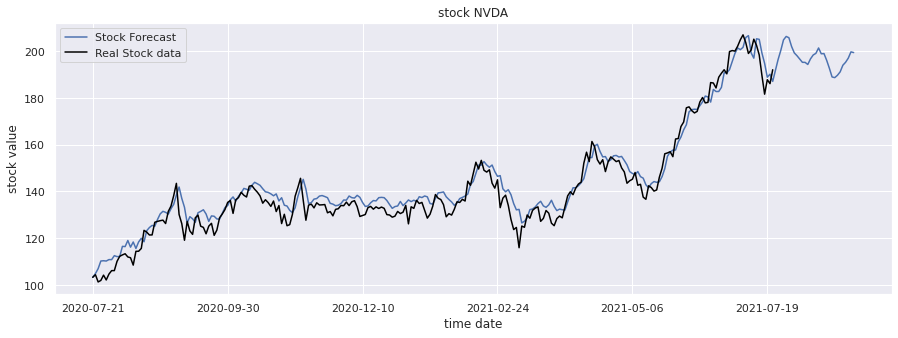

In [ ]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'Stock Forecast ')
plt.plot(df['Close'], label = 'Real Stock data', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::50], date_ori[::50])
plt.title(f'stock {ticker}')
plt.ylabel('stock value')
plt.xlabel('time date')
 
plt.show()